#Image Compression and Matrix Factorization

Matrix factorization is a way to find a set of basis vectors that describe a given dataset. Depending on the factorization used, the set of bases are different.

Using singular value decomposition (SVD) and nonnegative matrix factorization (NMF)

## Import the dataset

Using "[labeled faces in the wild](http://vis-www.cs.umass.edu/lfw/)" dataset.

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import fetch_lfw_people
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

img_count, img_height, img_width = lfw_people.images.shape
print('number of faces in dataset:', img_count)
print('image width in pixels     :', img_width)
print('image height in pixels    :', img_height)

number of faces in dataset: 1288
image width in pixels     : 37
image height in pixels    : 50


Each face is vectorized into a row in data matrix `X`

## Data transformation

Images are stored as a 3-dimensional array of size (1288, 50, 37). Transforming matrix `lfw_people.images` to a 2-dimensional array of size `image_count` by `image_width` * `image_height` with name `X`.


In [6]:
X = lfw_people.images.reshape(img_count, img_width * img_height)
X0_img = X[0].reshape(img_height, img_width)

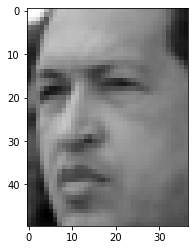

In [7]:
# each row of X is a vectorized image
plt.imshow(X0_img, cmap=plt.cm.gray);

In [8]:
def draw_img(img_vector, h=img_height, w=img_width):    
    plt.imshow( img_vector.reshape((h,w)), cmap=plt.cm.gray)
    plt.xticks(())
    plt.yticks(())

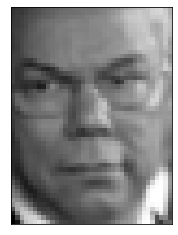

In [9]:
# checking draw_img function
draw_img(X[49])

Standardization for SVD


In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_std=False)
Xstd = scaler.fit_transform(X)

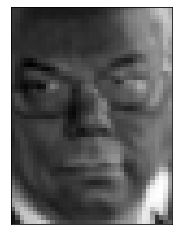

In [11]:
# standardization transforms image data
draw_img(Xstd[49])

### Inverse Transformation

We can recover the original data by putting the means back

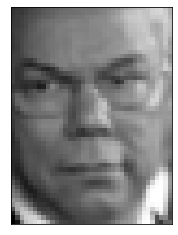

In [12]:
# inverse tranformation recovers original image units
Xorig = scaler.inverse_transform(Xstd)
draw_img(Xorig[49])

##Singular Value Decomposition (SVD)

$X_{std} = U S V^T$.


In [13]:
from numpy.linalg import svd

U, S, VT = svd(Xstd)

In [14]:
Xstd[0].shape

(1850,)

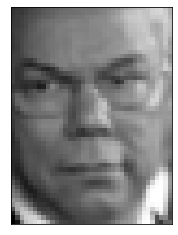

In [15]:
US = U*S
# reconstruct standardized images from matrix factors
Xhat = US @ VT[0:1288,:]

# inverse transform Xhat to remove standardization
Xhat_orig = scaler.inverse_transform(Xhat)

draw_img(Xhat_orig[49])

### Dimensionality reduction

We can describe each face using smaller portions of matrix factors. Because of how `US` and `VT` are ordered, the first portions of `US` and `VT` retain the most information.

I keep 500 columns of `US` and 500 rows of `VT` out of 1288.

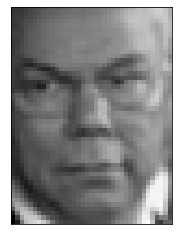

In [16]:
# reconstruct Xhat with less information: i.e. dimensionality is reduced
Xhat_500 = US[:, 0:500] @ VT[0:500, :]
# inverse transforms Xhat to remove standardization
Xhat_500_orig = scaler.inverse_transform(Xhat_500)
# draw recovered image
draw_img(Xhat_500_orig[49])

Using an even smaller number degrades the reconstruction; however, still the reconstructed image captures the "gist" of the original data. 

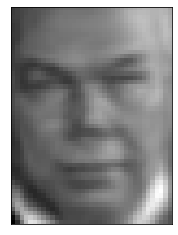

In [17]:
# reconstruct Xhat with less information: i.e. dimensionality is reduced
Xhat_100 = US[:, 0:100] @ VT[0:100, :]
# inverse transforms Xhat to remove standardization
Xhat_100_orig = scaler.inverse_transform(Xhat_100)
# draw recovered image
draw_img(Xhat_100_orig[49])

Writing a function for the dimensionality reduction and inverse transform

In [18]:
def dim_reduce(US_, VT_, dim=100):
    
    Xhat_ = US_[:, 0:dim] @ VT_[0:dim, :]
    
    return scaler.inverse_transform(Xhat_)

We can see how the increasing the rows and columns of matrix factors used increases fidelity of reconstructions

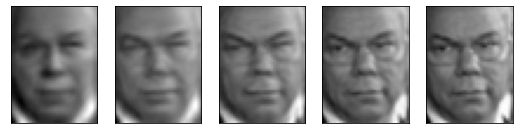

In [19]:
dim_vec = [50, 100, 200, 400, 800]

plt.figure(figsize=(1.8 * len(dim_vec), 2.4))

for i, d in enumerate(dim_vec):
    plt.subplot(1, len(dim_vec), i + 1)
    draw_img(dim_reduce(US, VT, d)[49])

##Matrix Factors and "Eigenfaces"

`VT` contains the set of "basis" vectors. In this setting rows of `VT` are called eigenfaces

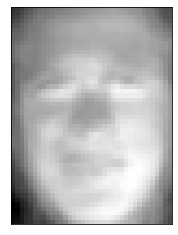

In [20]:
# each row of VT is an "eigenface"
draw_img(VT[0])

Plotting more eigenfaces show how the information in each eigenface are highlighting different components of photos

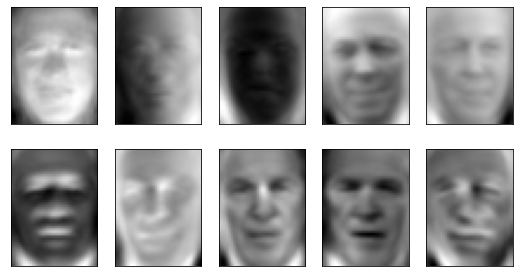

In [21]:
num_faces = 10
# each row of VT is an "eigenface"
plt.figure(figsize=(1.8 * 5, 2.4 * 2))

for i in range(0, 10):
    one_face = VT[i]
    plt.subplot(2, 5, i + 1)
    draw_img(one_face)

### Each face is a linear combination of eigenfaces

Reconstructing a face can be thought of as combining these eigenfaces according to some row of `US` (coefficients). 

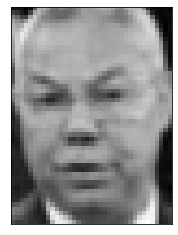

In [24]:
# each face is a linear combination of eigenfaces VT

face_num = 3 # which face to reconstruct?
dim = 300    # higher dim is more accurate fit
draw_img(scaler.inverse_transform(US[face_num, 0:dim] @ VT[:dim,:]))

##Nonnegative Matrix Factorization

Images are represented as light intensities between 0 and 255: i.e. nonnegative numbers.

NMF decomposes `X` into `W` and `H` such that $X \approx WH$. 

In [25]:
from sklearn.decomposition import NMF
model = NMF(n_components=200, init='nndsvd', random_state=0)
W = model.fit_transform(X)
H = model.components_

### Matrix factor H

NMF matrix factor `H` contains the set of basis faces.

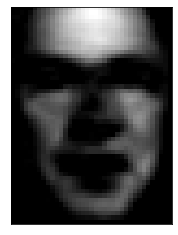

In [ ]:
draw_img(H[0])

The following is the sate of basis vectors of matrix H

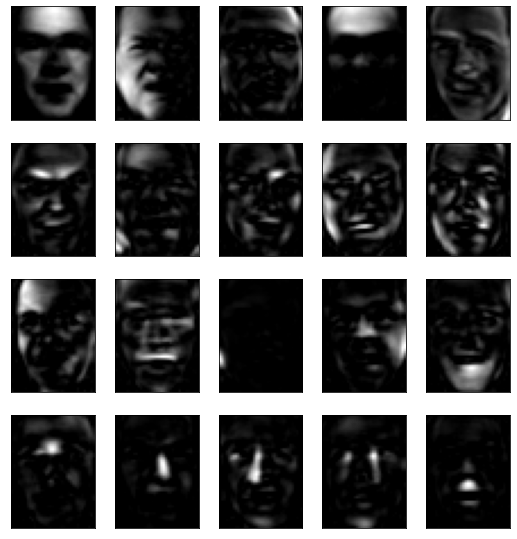

In [27]:
num_faces = 20
plt.figure(figsize=(1.8 * 5, 2.4 * 4))

for i in range(0, num_faces):
    one_face = VT[i]
    plt.subplot(4, 5, i + 1)
    draw_img(H[i])

This is very different than what SVD chose.  

However, each face is still a linear combination of matrix `H`

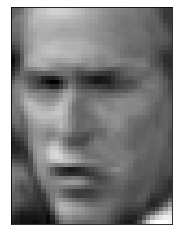

In [ ]:
draw_img(W[30]@H) # using 200 NMF basis vectors

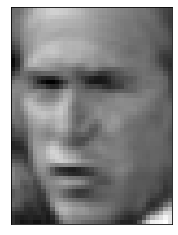

In [ ]:
draw_img(dim_reduce(US, VT, 200)[30]) # using 200 SVD basis vectors

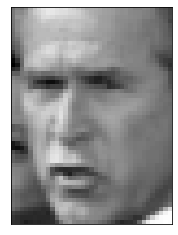

In [ ]:
draw_img(X[30]) # original image 